## ✈️ Étude de la problématique

Le **turbofan** est un type de **moteur à turbine à gaz** largement utilisé dans l'aviation commerciale pour sa capacité à fournir une **poussée élevée** tout en étant plus **économe en carburant** et **moins bruyant** que les moteurs turbojets classiques. Il est constitué de plusieurs **composants essentiels** : **entrée d'air**, **compresseurs** (basse et haute pression), **chambre de combustion**, **turbines** et **buse d'échappement**.  
Cependant, au fil du temps, et sous l'effet de conditions opérationnelles sévères (**corrosion**, **usure**, **érosion**), le moteur subit une **dégradation progressive** qui affecte sa **fiabilité** et ses **performances**.  
La complexité de la structure du **turbofan**, combinée à l'**absence de mesures directes** pour certains **paramètres de santé**, rend la **prédiction de la durée de vie restante (RUL)** particulièrement **difficile**, nécessitant des approches avancées de **maintenance prédictive** basées sur les **données**.



## 🛠️ Environnement de développement des modèles

- **Ce notebook sera utilisé pour entraîner les modèles et mettre en place l'API.**

---

## 🎯 Portée du projet

- Pendant leur utilisation, les pièces d’un avion peuvent se dégrader, ce qui impacte leur fiabilité et leurs performances.
- Ce projet de machine learning a pour but de **prédire la durée de vie restante (Remaining Useful Life - RUL)** d’un moteur d’avion, en se basant sur l’ensemble des données de son cycle de vie.

- Pour cela,on essaiera les modeles états de l'art dans la modelisation et al prédictions des séries temporelles :

  - **LSTM**
  - **XGBOOST**
- Ces modèles sont testés sur le **jeu de données C-MAPSS** de la NASA afin d’évaluer combien de temps le moteur peut encore fonctionner avant de tomber en panne.

---

## 🔧 Structure du jeu de données

Le jeu de données **C-MAPSS** (*Turbofan Engine Degradation Simulation*) de la NASA fournit des données temporelles simulées allant jusqu'à la panne de plusieurs moteurs.

Il est divisé en **quatre sous-ensembles** : **FD001**, **FD002**, **FD003** et **FD004**, et chacun contient trois fichiers :
- Un fichier d'**entraînement** (`train_FDXXX.txt`),
- Un fichier de **test** (`test_FDXXX.txt`),
- Un fichier indiquant la **durée de vie restante réelle (RUL)** pour chaque moteur de test (`RUL_FDXXX.txt`).

---

### 📚 Exemple : sous-ensemble FD001

- **100 moteurs pour l'entraînement**,
- **100 moteurs pour les tests**,
- Une seule condition de fonctionnement et un seul mode de panne.

> Pour chaque moteur en entraînement, les données vont **jusqu’à la panne** (la dernière ligne correspond à la défaillance).
>
> En revanche, pour les moteurs de test, les données **s’arrêtent avant la panne**.  
> Le fichier **RUL** indique combien de cycles restaient avant la panne.

---

### 🧩 Structure des colonnes

Chaque ligne du fichier (sans en-tête) contient **26 colonnes** :

- **Colonne 1** : Identifiant du moteur (ID unique),
- **Colonne 2** : Numéro du cycle de fonctionnement (remis à zéro pour chaque moteur),
- **Colonnes 3 à 5** : Paramètres de fonctionnement (ex : environnement ou réglages moteur),
- **Colonnes 6 à 26** : Valeurs de capteurs (21 capteurs mesurant température, pression, débit, etc.).

> **Note :** Les noms physiques des capteurs ne sont **pas précisés** dans le dataset.



In [ ]:
# import required libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
#import keras  # Updated: Remove this line, we'll use tf.keras
import keras.backend as K # this line is ok
# Updated: Import layers and models from tensorflow.keras
from tensorflow.keras.layers import Activation, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential, load_model
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import xgboost
import time
from tqdm import tqdm

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

In [ ]:
import kagglehub

# Download the dataset
path = kagglehub.dataset_download("behrad3d/nasa-cmaps")

print("Path to dataset files:", path)

# List contents
import os
print(os.listdir(path))


Path to dataset files: /kaggle/input/nasa-cmaps
['CMaps']


In [ ]:
import pandas as pd
col_names = (['unit_nr','time_cycles'] +
             [f'setting_{i}' for i in range(1,4)] +
             [f's_{i}' for i in range(1,22)])
train = pd.read_csv('/kaggle/input/nasa-cmaps/CMaps/train_FD001.txt', sep='\s+', header=None, names=col_names)
test  = pd.read_csv('/kaggle/input/nasa-cmaps/CMaps/test_FD001.txt',  sep='\s+', header=None, names=col_names)
truth = pd.read_csv('/kaggle/input/nasa-cmaps/CMaps/RUL_FD001.txt',   sep='\s+', header=None, names=['RUL'])

# Preview the training data
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Truth RUL shape:", truth.shape)
train.info()
train.head()
#truth.head()


Train shape: (20631, 26)
Test shape: (13096, 26)
Truth RUL shape: (100, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_nr      20631 non-null  int64  
 1   time_cycles  20631 non-null  int64  
 2   setting_1    20631 non-null  float64
 3   setting_2    20631 non-null  float64
 4   setting_3    20631 non-null  float64
 5   s_1          20631 non-null  float64
 6   s_2          20631 non-null  float64
 7   s_3          20631 non-null  float64
 8   s_4          20631 non-null  float64
 9   s_5          20631 non-null  float64
 10  s_6          20631 non-null  float64
 11  s_7          20631 non-null  float64
 12  s_8          20631 non-null  float64
 13  s_9          20631 non-null  float64
 14  s_10         20631 non-null  float64
 15  s_11         20631 non-null  float64
 16  s_12         20631 non-null  float64
 17  s_13         

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## 🔎 Résumé du dataset FD001 (C-MAPSS)

Le dataset **C-MAPSS** sous-ensemble **FD001** contient des **données temporelles** collectées sur plusieurs **moteurs d’avion** jusqu’à leur **panne**. Chaque ligne représente l’état d’un moteur à un **cycle donné**, avec **26 colonnes** : un **identifiant moteur** (`unit_nr`), un **compteur de cycles** (`time_cycles`), **trois paramètres opérationnels** (`setting_1`, `setting_2`, `setting_3`) et **21 mesures de capteurs** (`s_1` à `s_21`).  
Les **paramètres opérationnels** varient très peu, ce qui confirme qu’il s’agit d’une **seule condition de fonctionnement** (spécifique à FD001). Parmi les capteurs, certains présentent des **variations sensibles** liées à la **dégradation du moteur** (par exemple : `s_2`, `s_3`, `s_4`), tandis que d’autres restent **quasiment constants** et peuvent être **supprimés** pour réduire le **bruit** dans les données.  
Avant d’entraîner un modèle, il est essentiel de **normaliser** les capteurs retenus, de **calculer la durée de vie restante** (**RUL**) pour chaque observation, puis de **structurer les données en séquences temporelles** (par exemple, des fenêtres de **30 cycles**) adaptées à un apprentissage par **réseaux de neurones récurrents** (**RNN**, **LSTM**, **GRU**). Ce dataset est idéal pour développer des **modèles prédictifs de maintenance**.





In [ ]:
# Commençant  l'EDA :
# un apperçu sur les valeurs de chaque variables du dataset :
train.describe()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


# Préparation des Données C-MAPSS

## Aucune valeur manquante
- L'ensemble de données **C-MAPSS** est un jeu simulé et propre — il ne contient **aucune valeur manquante**.
- Chaque lecture de capteur est enregistrée à **chaque cycle**, bien que certains capteurs puissent produire des **valeurs constantes** ou du **bruit**.
- **Aucune imputation** n'est nécessaire. Toutefois, il est important de prendre en compte :
  - Le **bruit** des capteurs ;
  - Le fait que les moteurs commencent avec des **niveaux d'usure initiale variables**.
- Les anomalies éventuelles sont plutôt dues à des **effets physiques** (capteurs peu informatifs ou bruités) plutôt qu’à des valeurs nulles.

*(Source : catalog.data.gov)*

---

## Gestion des anomalies
- Tous les moteurs commencent dans un **état sain** et terminent par une **défaillance**.
- Il n'existe donc **pas d'anomalies majeures** ou de **valeurs aberrantes** à supprimer, excepté :
  - Les capteurs dont les mesures restent **constantes** ou **sans tendance significative**.
- Ces capteurs pourront être identifiés et supprimés lors de l’analyse des variables (*feature engineering*).
- À noter : l'**usure initiale** de chaque moteur est **inconnue** et constitue une **variabilité normale**.

*(Source : catalog.data.gov)*

---

## Calcul du RUL (Remaining Useful Life) pour les données d'entraînement
- Dans l'ensemble d'entraînement, un moteur est considéré en **panne** lorsque **RUL = 0**.
- Le **Remaining Useful Life** est calculé pour chaque cycle de chaque moteur selon la formule :

```math
RUL = (\text{Cycle maximum du moteur}) - (\text{Cycle actuel})



Vérification des valeurs manquantes :
unit_nr        0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64


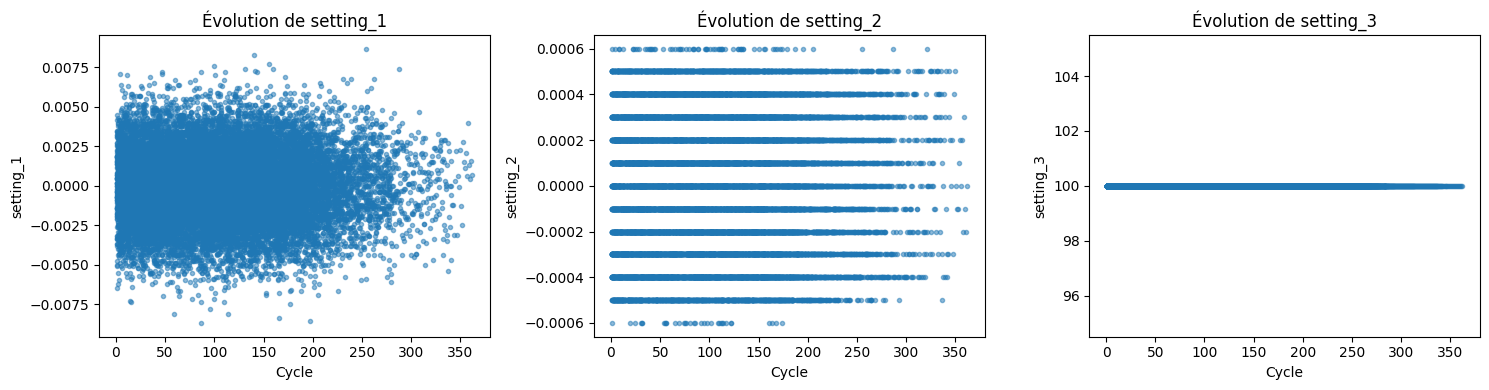

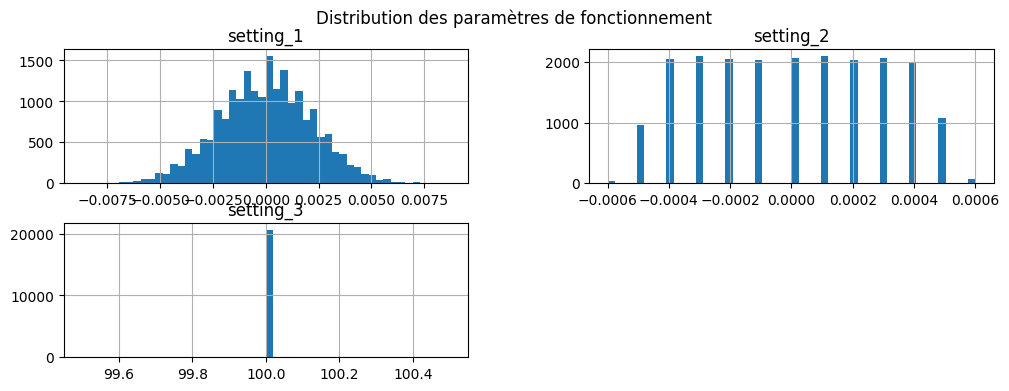


Statistiques descriptives des capteurs :
        count         mean           std        min        25%        50%  \
s_1   20631.0   518.670000  6.537152e-11   518.6700   518.6700   518.6700   
s_2   20631.0   642.680934  5.000533e-01   641.2100   642.3250   642.6400   
s_3   20631.0  1590.523119  6.131150e+00  1571.0400  1586.2600  1590.1000   
s_4   20631.0  1408.933782  9.000605e+00  1382.2500  1402.3600  1408.0400   
s_5   20631.0    14.620000  3.394700e-12    14.6200    14.6200    14.6200   
s_6   20631.0    21.609803  1.388985e-03    21.6000    21.6100    21.6100   
s_7   20631.0   553.367711  8.850923e-01   549.8500   552.8100   553.4400   
s_8   20631.0  2388.096652  7.098548e-02  2387.9000  2388.0500  2388.0900   
s_9   20631.0  9065.242941  2.208288e+01  9021.7300  9053.1000  9060.6600   
s_10  20631.0     1.300000  4.660829e-13     1.3000     1.3000     1.3000   
s_11  20631.0    47.541168  2.670874e-01    46.8500    47.3500    47.5100   
s_12  20631.0   521.413470  7.3755

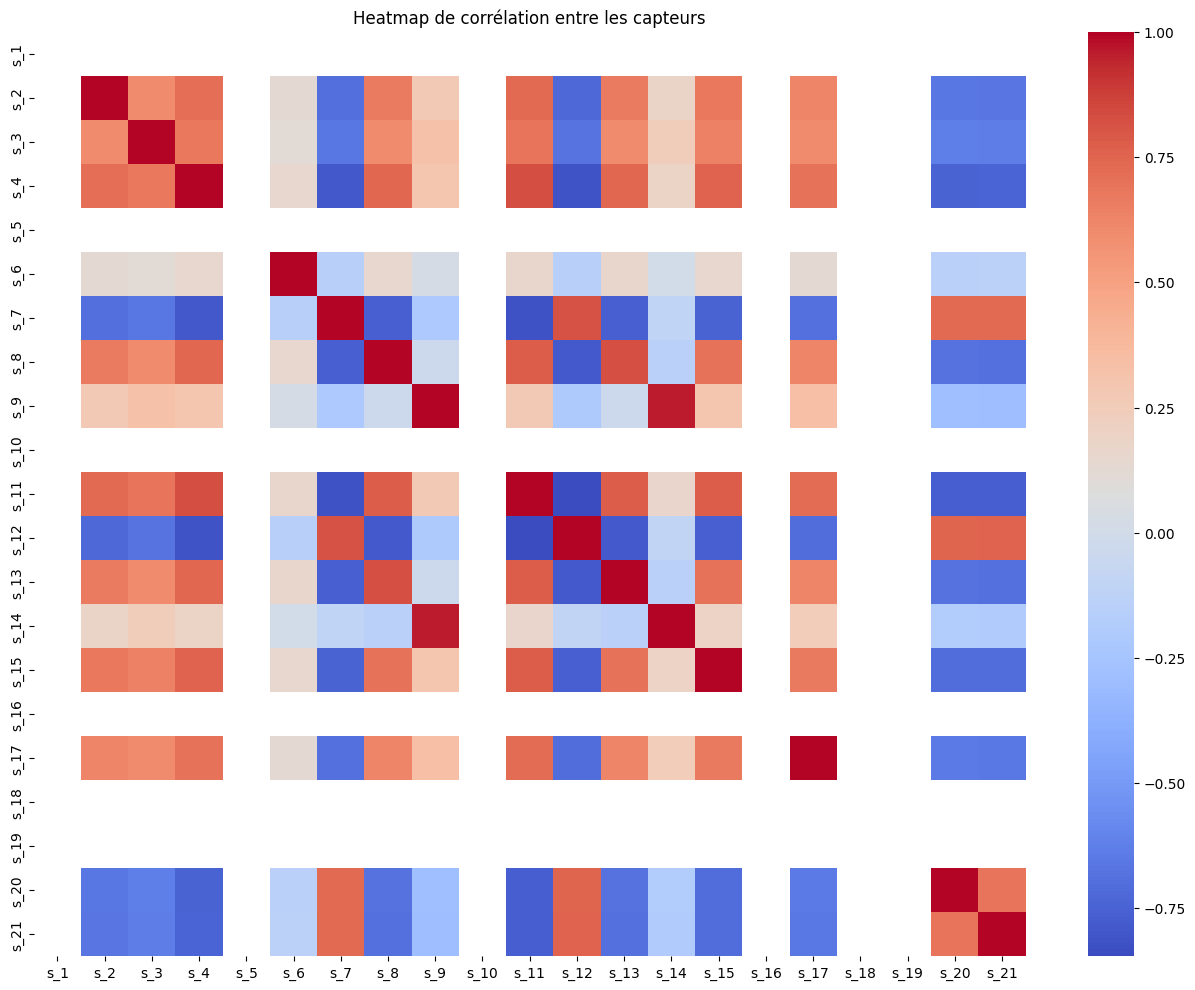

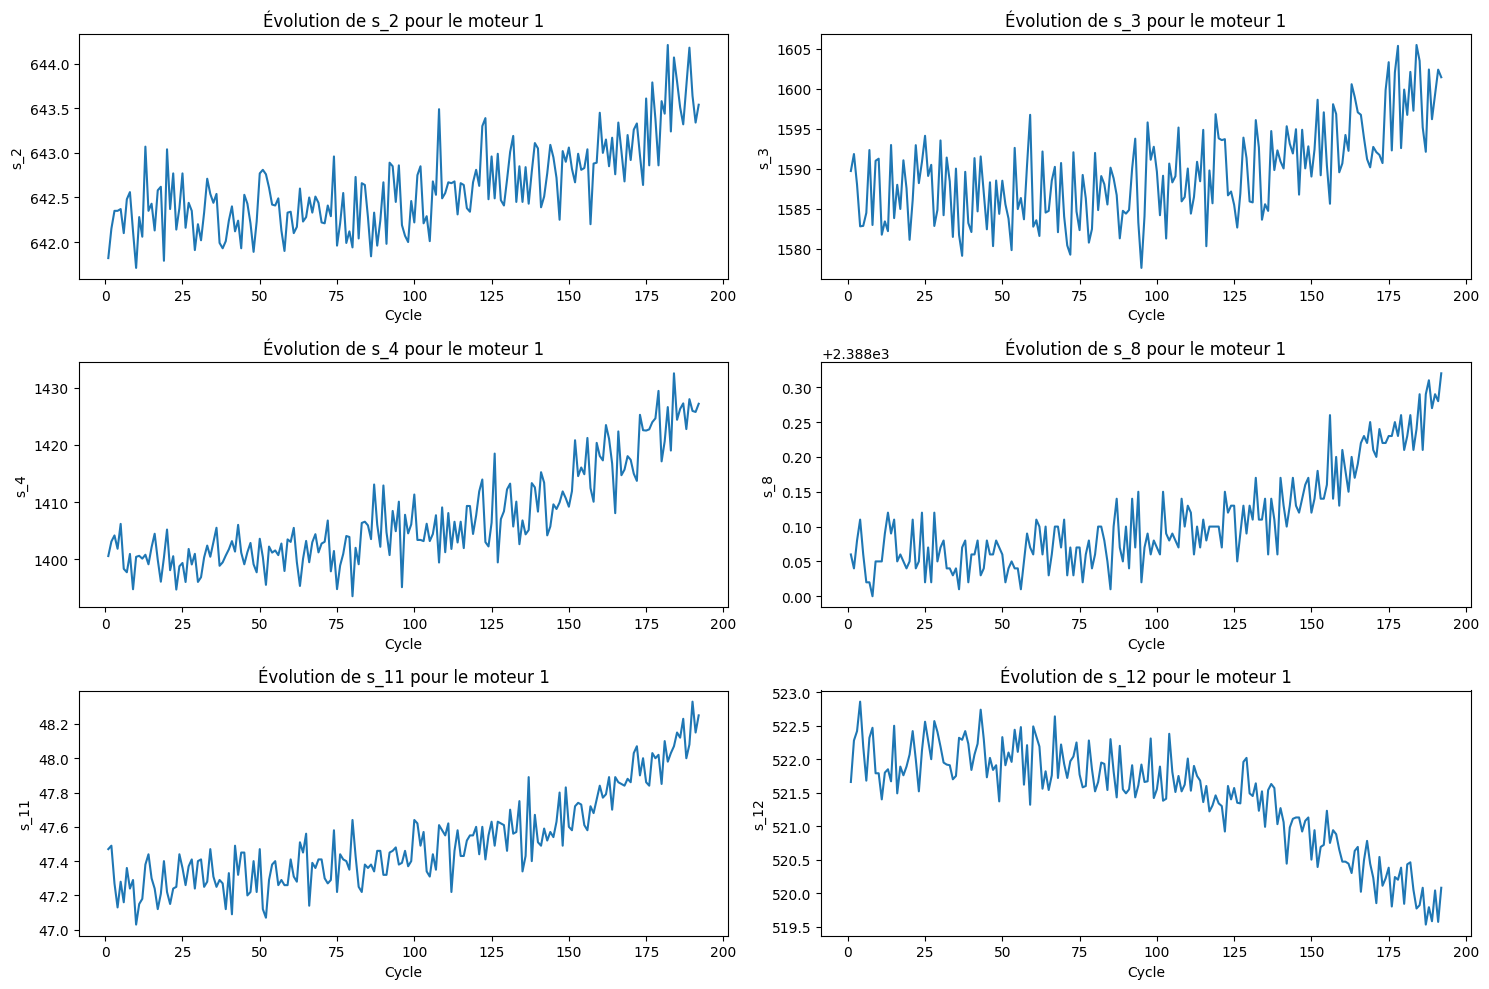

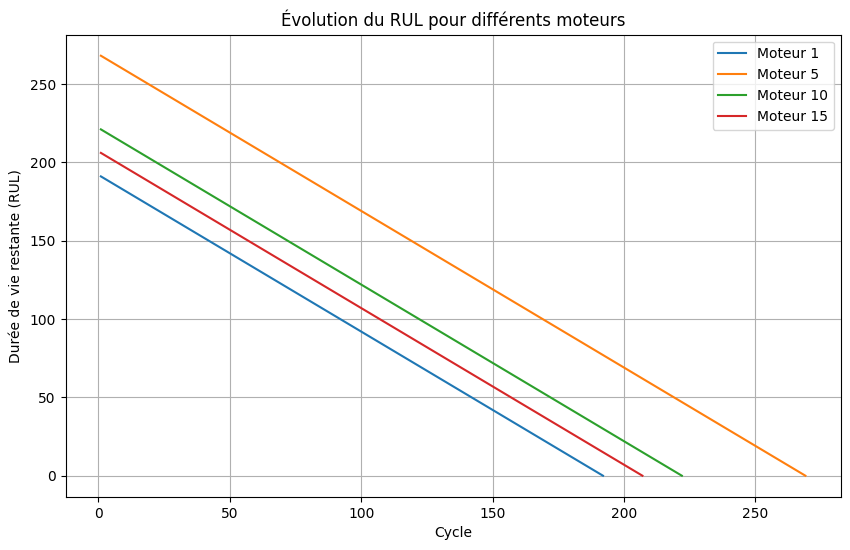

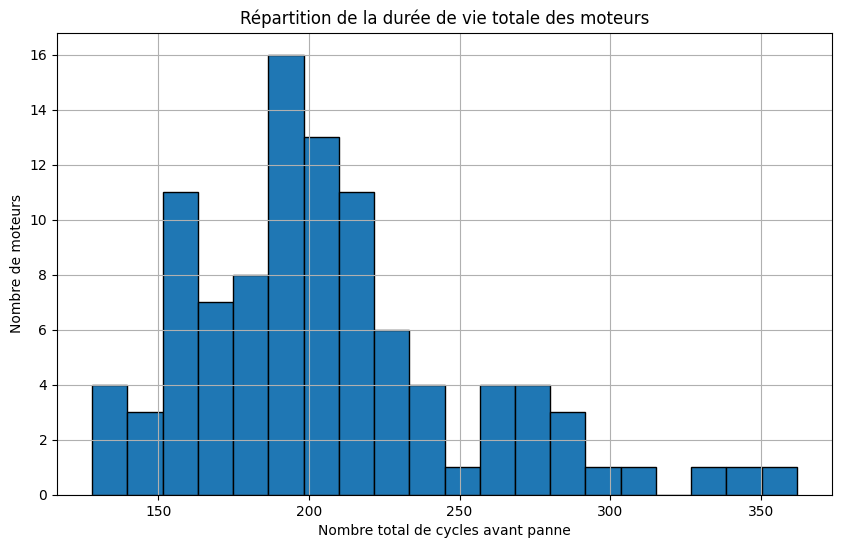

In [ ]:

print("\nVérification des valeurs manquantes :")
print(train.isnull().sum())

# 🔧 2. Analyse des paramètres de fonctionnement (settings)
settings = ['setting_1', 'setting_2', 'setting_3']

# Plot des settings
plt.figure(figsize=(15,4))
for i, setting in enumerate(settings):
    plt.subplot(1,3,i+1)
    plt.plot(train['time_cycles'], train[setting], '.', alpha=0.5)
    plt.title(f'Évolution de {setting}')
    plt.xlabel('Cycle')
    plt.ylabel(setting)
plt.tight_layout()
plt.show()

# Histogrammes des settings
train[settings].hist(bins=50, figsize=(12,4))
plt.suptitle('Distribution des paramètres de fonctionnement')
plt.show()

# 🛠️ 3. Analyse des capteurs
sensors = [f's_{i}' for i in range(1, 22)]

# Statistiques descriptives
print("\nStatistiques descriptives des capteurs :")
print(train[sensors].describe().T)

# Corrélation entre les capteurs
plt.figure(figsize=(16,12))
corr = train[sensors].corr()
sns.heatmap(corr, cmap="coolwarm", annot=False)
plt.title("Heatmap de corrélation entre les capteurs")
plt.show()

# Exemple d'évolution de quelques capteurs sur un moteur
engine_id = 1
subset = train[train['unit_nr'] == engine_id]

plt.figure(figsize=(15,10))
for idx, sensor in enumerate(['s_2', 's_3', 's_4', 's_8', 's_11', 's_12']):
    plt.subplot(3,2,idx+1)
    plt.plot(subset['time_cycles'], subset[sensor])
    plt.title(f'Évolution de {sensor} pour le moteur {engine_id}')
    plt.xlabel('Cycle')
    plt.ylabel(sensor)
plt.tight_layout()
plt.show()

# 📈 4. Analyse du comportement temporel
# Calcul du RUL : (max cycle par moteur) - (cycle actuel)
rul_per_engine = train.groupby('unit_nr')['time_cycles'].max().reset_index()
rul_per_engine.columns = ['unit_nr', 'max_cycle']
train = train.merge(rul_per_engine, on='unit_nr')
train['RUL'] = train['max_cycle'] - train['time_cycles']

# Visualisation de la décroissance du RUL pour quelques moteurs
plt.figure(figsize=(10,6))
for engine_id in [1, 5, 10, 15]:
    subset = train[train['unit_nr'] == engine_id]
    plt.plot(subset['time_cycles'], subset['RUL'], label=f'Moteur {engine_id}')
plt.xlabel('Cycle')
plt.ylabel('Durée de vie restante (RUL)')
plt.title('Évolution du RUL pour différents moteurs')
plt.legend()
plt.grid(True)
plt.show()

# 📊 5. Répartition du nombre de cycles avant panne par moteur
engine_cycles = train.groupby('unit_nr')['time_cycles'].max()

plt.figure(figsize=(10,6))
plt.hist(engine_cycles, bins=20, edgecolor='black')
plt.xlabel('Nombre total de cycles avant panne')
plt.ylabel('Nombre de moteurs')
plt.title('Répartition de la durée de vie totale des moteurs')
plt.grid(True)
plt.show()

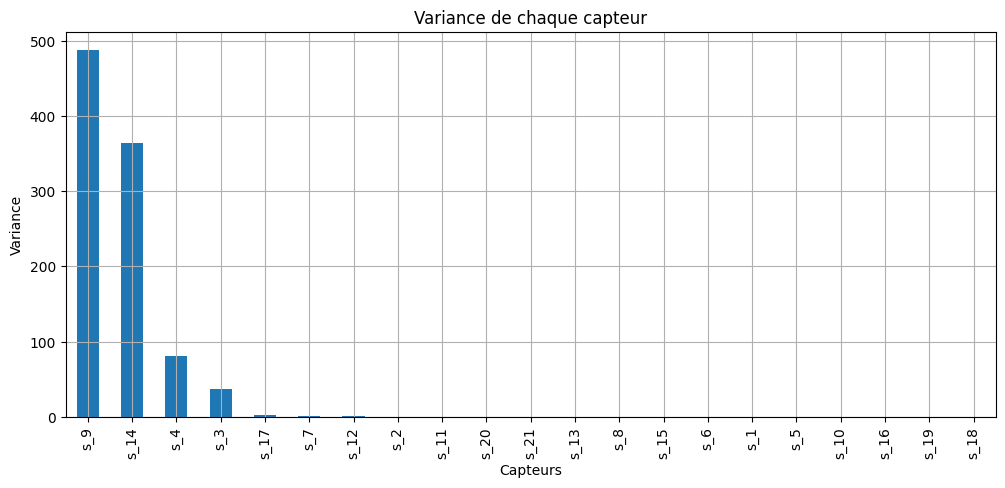

Capteurs sélectionnés automatiquement (variance > 0.01) : ['s_2', 's_3', 's_4', 's_7', 's_9', 's_11', 's_12', 's_14', 's_17', 's_20', 's_21']


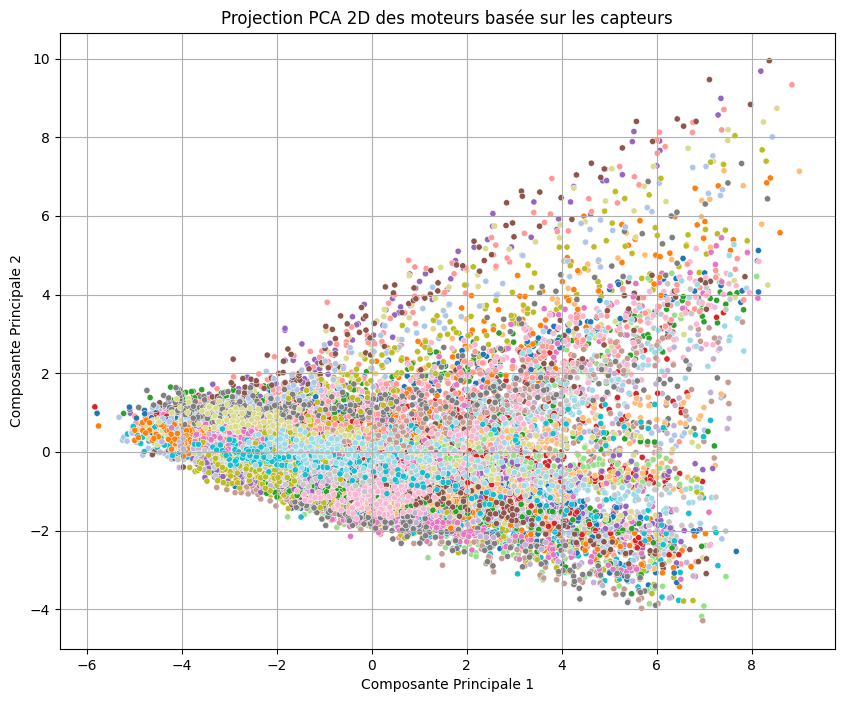

Variance expliquée par PC1 et PC2 : 79.56%


In [ ]:
# 📚 Import des bibliothèques nécessaires pour l'EDA avancée
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 🔍 Sélection automatique des capteurs utiles

# Supposons que 'train' contient déjà les colonnes capteurs 's_1' à 's_21'
sensor_cols = [col for col in train.columns if col.startswith('s_')]

# Calcul de la variance de chaque capteur
variances = train[sensor_cols].var()

# Visualiser les variances
plt.figure(figsize=(12,5))
variances.sort_values(ascending=False).plot(kind='bar')
plt.title('Variance de chaque capteur')
plt.xlabel('Capteurs')
plt.ylabel('Variance')
plt.grid(True)
plt.show()

# Garder uniquement les capteurs avec une variance significative
# Seuil arbitraire : > 0.01 (ajustable)
selected_sensors = variances[variances > 0.01].index.tolist()

print(f"Capteurs sélectionnés automatiquement (variance > 0.01) : {selected_sensors}")

# 2. 🎯 PCA 2D pour visualisation de la structure

# Standardiser les données des capteurs sélectionnés
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train[selected_sensors])

# Application du PCA pour réduire à 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Stockage dans un DataFrame pour tracer
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['unit_nr'] = train['unit_nr'].values

# Visualisation : projection PCA
plt.figure(figsize=(10,8))
sns.scatterplot(x='PC1', y='PC2', hue='unit_nr', data=pca_df, palette='tab20', legend=None, s=20)
plt.title('Projection PCA 2D des moteurs basée sur les capteurs')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.grid(True)
plt.show()

# 3. 🧠 Variance expliquée par PCA
print(f"Variance expliquée par PC1 et PC2 : {np.sum(pca.explained_variance_ratio_)*100:.2f}%")


# 📊 Analyse des Graphiques EDA

## 1. Distribution des paramètres opérationnels (`setting_1`, `setting_2`, `setting_3`)
- **Observation :** Les histogrammes et les courbes montrent que `setting_1`, `setting_2`, `setting_3` présentent des **variations très faibles** autour de valeurs proches de 0 ou 100.
- **Interprétation :** Cela confirme qu’il s’agit d’une **seule condition de fonctionnement** (spécifique à FD001).
- **Conséquence :** Ces paramètres n’apportent **pas d'information utile** pour prédire le RUL et peuvent être **supprimés**.

---

## 2. Distribution et variance des capteurs (`s_1` à `s_21`)
- **Observation :** Certains capteurs (`s_1`, `s_5`, `s_6`, `s_10`, `s_16`, `s_18`, `s_19`) montrent une **très faible variance**, tandis que d’autres (`s_2`, `s_3`, `s_4`, etc.) présentent une **évolution significative**.
- **Interprétation :** Les capteurs à faible variance doivent être **éliminés** pour éviter d'introduire du **bruit** dans l'entraînement du modèle. Les capteurs dynamiques sont **importants** pour détecter l’usure.

---

## 3. Heatmap de corrélation des capteurs
- **Observation :** La heatmap révèle que **certains capteurs sont fortement corrélés** entre eux.
- **Interprétation :** Il est possible de **réduire la redondance** en supprimant certains capteurs fortement corrélés. Cela pourrait simplifier le modèle sans perte d'information critique.

---

## 4. Évolution du RUL en fonction des cycles
- **Observation :** Le RUL **décroît de manière linéaire** au fil des cycles pour chaque moteur.
- **Interprétation :** Cela est **cohérent avec le comportement attendu** d'un moteur vieillissant. Cela valide l'hypothèse de modéliser le RUL à partir des mesures capteurs au cours du temps.

---

## 5. Répartition du nombre total de cycles avant panne
- **Observation :** La majorité des moteurs tombent en panne **entre 150 et 270 cycles**.
- **Interprétation :** Il existe une **variabilité naturelle** dans la robustesse des moteurs. Cela souligne la nécessité de modéliser le RUL de manière personnalisée pour chaque moteur.

---

## 6. PCA (Analyse en Composantes Principales)
- **Observation :** La projection en 2D montre une **dispersion large** des moteurs sans formation de clusters nets.
- **Interprétation :** Il n'y a **pas de regroupements naturels** dans les données. Cela justifie pleinement l'usage de **modèles séquentiels** (comme LSTM ou GRU) plutôt que des modèles de clustering classiques.

---

# ✨ Résumé Global

| Aspect analysé | Résultat |
|:---|:---|
| **Settings** | Peu d’utilité ➔ À supprimer |
| **Capteurs** | Sélectionner ceux avec forte variance |
| **Corrélations** | Détecter et réduire les redondances |
| **RUL** | Décroissance linéaire attendue |
| **Cycles moteur** | Variabilité importante |
| **PCA** | Dispersion large sans clusters |

---

# ✅ Conclusion

Ton EDA valide que :
- Les paramètres opérationnels et capteurs constants doivent être écartés.
- Une sélection des capteurs utiles est nécessaire.
- Les données sont adaptées pour un modèle séquentiel comme **LSTM** ou **GRU**.
- La préparation est optimale pour passer à la **modélisation du RUL** !




In [ ]:
# Suppression directe des capteurs inutiles dans le DataFrame 'train'
train_df = train.copy()
train_df.drop(columns=[
    'setting_3',
    's_1',
    's_5',
    's_16',
    's_18',
    's_19'
], inplace=True)

# Vérification rapide
print("Colonnes restantes :", train_df.columns.tolist())


Colonnes restantes : ['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 's_2', 's_3', 's_4', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11', 's_12', 's_13', 's_14', 's_15', 's_17', 's_20', 's_21', 'max_cycle', 'RUL']


In [ ]:
# Fonction pour préparer les données d'entraînement et créer la colonne "RUL"
# Le RUL représente le nombre de cycles restants avant la panne

def preparer_donnees_train(data, facteur=0):
    df = data.copy()  # Copier le DataFrame pour éviter de modifier l'original

    # Calcul du dernier cycle pour chaque moteur
    fd_RUL = df.groupby('unit_nr')['time_cycles'].max().reset_index()
    fd_RUL.columns = ['unit_nr', 'max']

    # Fusionner l'information du cycle maximum dans le DataFrame principal
    df = df.merge(fd_RUL, on=['unit_nr'], how='left')

    # Calcul du RUL : nombre de cycles restants avant la panne
    df['RUL'] = df['max'] - df['time_cycles']

    # Supprimer la colonne temporaire 'max'
    df.drop(columns=['max'], inplace=True)

    # Retourner uniquement les données dont le cycle est supérieur au facteur (facultatif)
    return df[df['time_cycles'] > facteur]
preparer_donnees_train(train_df)

,unit_nr,time_cycles,setting_1,setting_2,s_2,s_3,s_4,s_6,s_7,s_8,...,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21,max_cycle,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,...,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,...,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,...,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,...,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,...,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,192,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,21.61,551.43,2388.19,...,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,200,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,21.61,550.86,2388.23,...,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,200,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,21.61,550.94,2388.24,...,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,200,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,21.61,550.68,2388.25,...,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,200,1


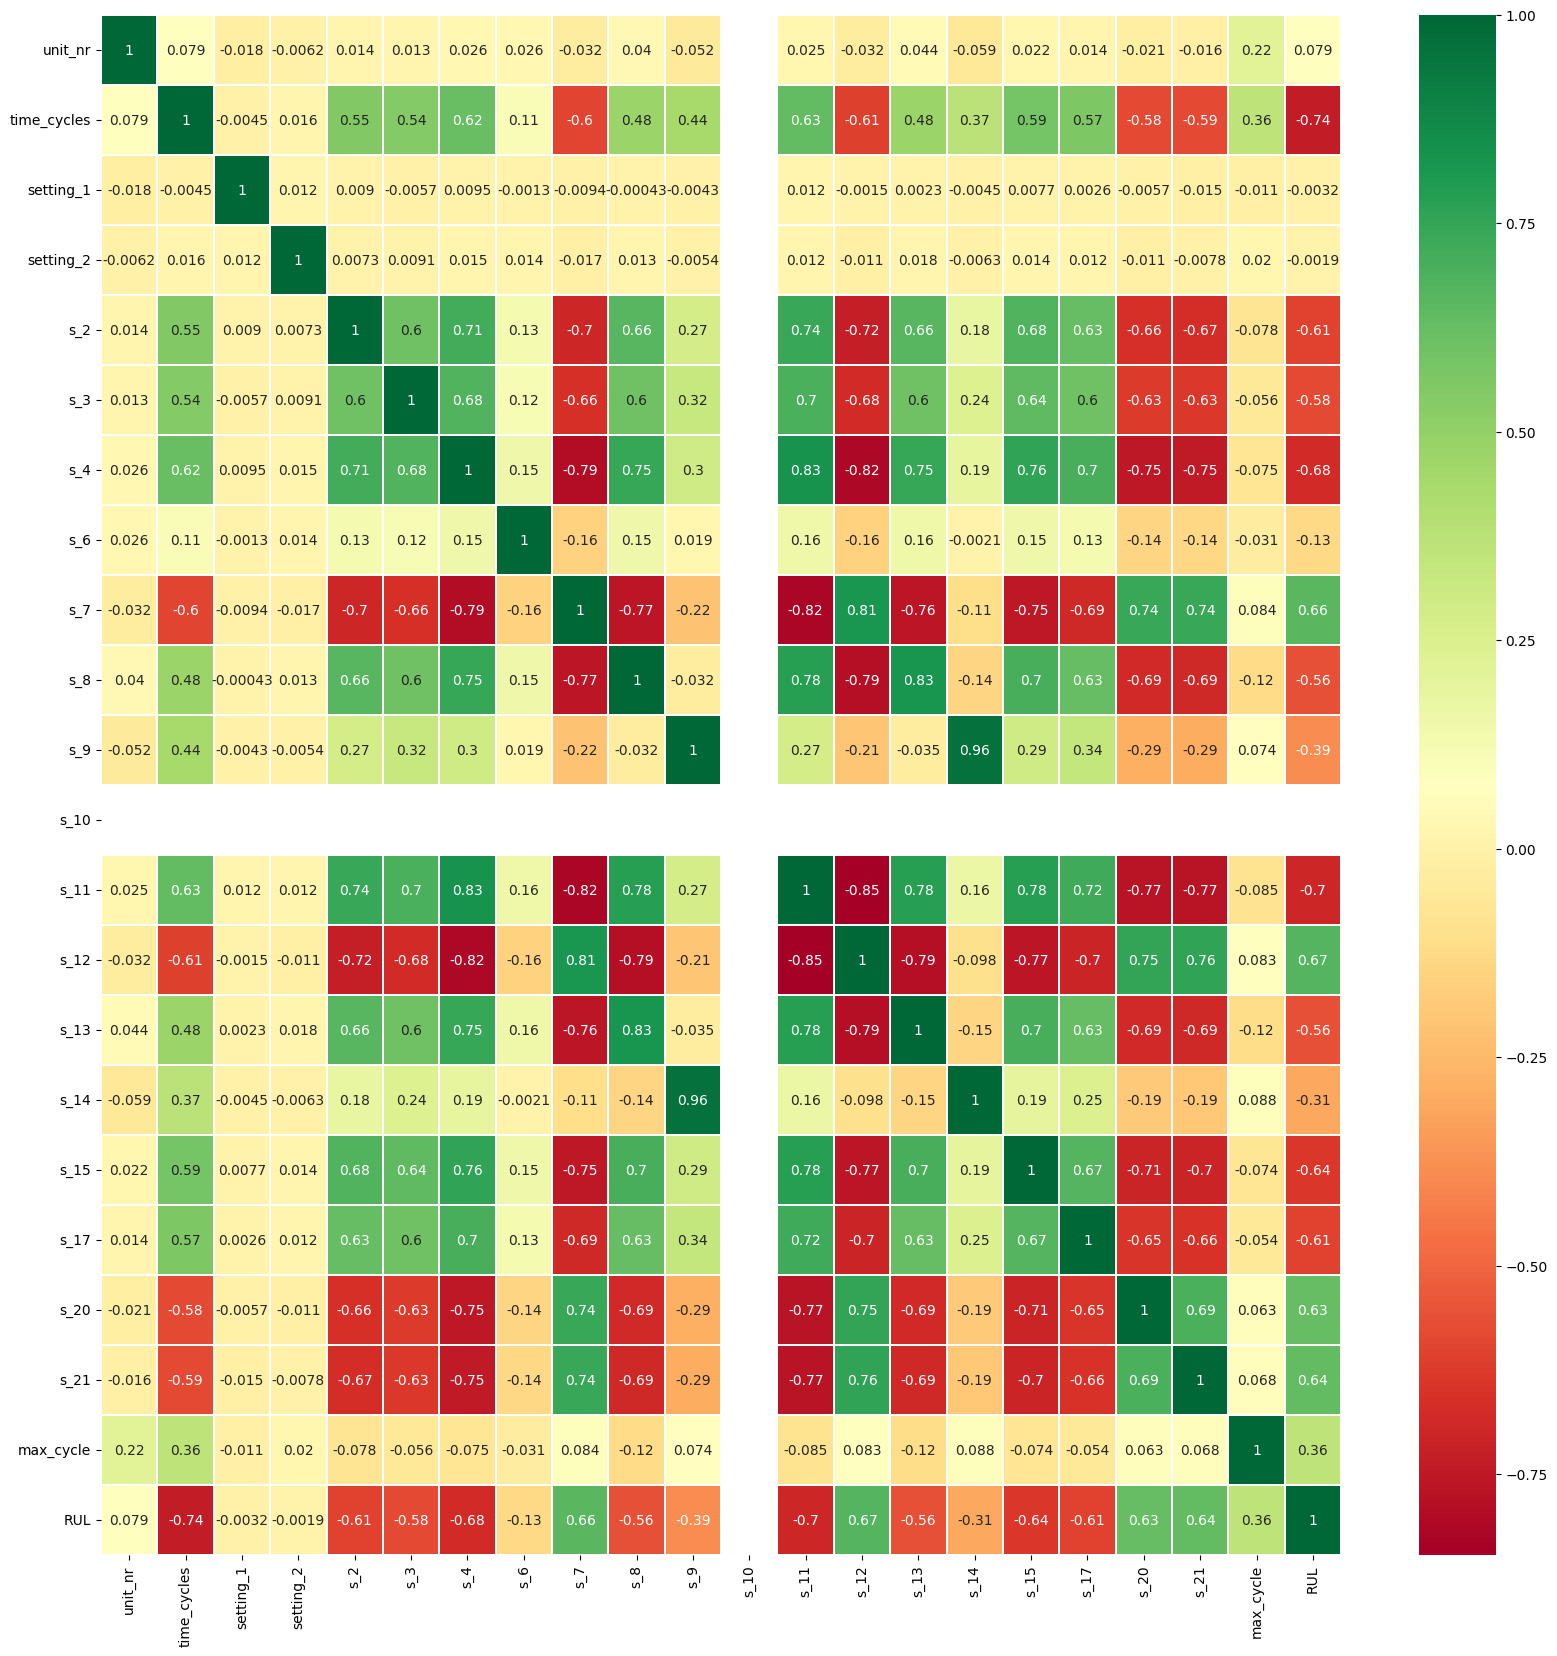

In [ ]:
sns.heatmap(train_df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

In [ ]:
#Error Function for Competitive Data
def score(y_true,y_pred,a1=10,a2=13):
    score = 0
    d = y_pred - y_true
    for i in d:
        if i >= 0 :
            score += math.exp(i/a2) - 1
        else:
            score += math.exp(- i/a1) - 1
    return score

In [ ]:
def score_func(y_true,y_pred):
    lst = [round(score(y_true,y_pred),2),
          round(mean_absolute_error(y_true,y_pred),2),
          round(mean_squared_error(y_true,y_pred),2)**0.5,
          round(r2_score(y_true,y_pred),2)]

    print(f' compatitive score {lst[0]}')
    print(f' mean absolute error {lst[1]}')
    print(f' root mean squared error {lst[2]}')
    print(f' R2 score {lst[3]}')
    return [lst[1], round(lst[2],2), lst[3]*100]

In [ ]:
unit_number = pd.DataFrame(train_df["unit_nr"])
clean_df = train.drop(columns = ['unit_nr','setting_1','setting_2', 's_4', 's_9',
    's_13', 's_15', 's_17'])
clean_df.head()

,time_cycles,setting_3,s_1,s_2,s_3,s_5,s_6,s_7,s_8,s_10,s_11,s_12,s_14,s_16,s_18,s_19,s_20,s_21,max_cycle,RUL
0,1,100.0,518.67,641.82,1589.70,14.62,21.61,554.36,2388.06,1.3,47.47,521.66,8138.62,0.03,2388,100.0,39.06,23.4190,192,191
1,2,100.0,518.67,642.15,1591.82,14.62,21.61,553.75,2388.04,1.3,47.49,522.28,8131.49,0.03,2388,100.0,39.00,23.4236,192,190
2,3,100.0,518.67,642.35,1587.99,14.62,21.61,554.26,2388.08,1.3,47.27,522.42,8133.23,0.03,2388,100.0,38.95,23.3442,192,189
3,4,100.0,518.67,642.35,1582.79,14.62,21.61,554.45,2388.11,1.3,47.13,522.86,8133.83,0.03,2388,100.0,38.88,23.3739,192,188
4,5,100.0,518.67,642.37,1582.85,14.62,21.61,554.00,2388.06,1.3,47.28,522.19,8133.80,0.03,2388,100.0,38.90,23.4044,192,187


# 📚 Nettoyage du dataset avant modélisation

Avant d'entraîner notre modèle prédictif, il est essentiel de **supprimer certaines colonnes inutiles** ou **non informatives** afin d'améliorer la qualité des données et la performance du modèle.  
Voici l'explication détaillée des colonnes retirées et du code correspondant.

---

## ✂️ Colonnes supprimées et justification

| Colonne | Raison de suppression |
|:---|:---|
| `setting_1` | Paramètre de fonctionnement avec très peu de variation ➔ peu informatif. |
| `setting_2` | Même raison que `setting_1`. |
| `s_4`  | Capteur présentant peu de dynamique utile pour la prédiction du RUL. |
| `s_5` | Capteur pratiquement constant, peu corrélé au vieillissement moteur. |
| `s_9`| Capteur fortement redondant avec d'autres mesures (pression, température). |
| `s_13`  | Très fortement corrélé à `s_8` (Nc) ➔ risque de surapprentissage, donc supprimé. |
| `s_15` | Capteur lié à la consommation carburant, faible variation utile ici. |
| `s_17` | Commande moteur ➔ ce n’est pas une mesure physique directe. |
| `s_18` | Même raison que `s_17`. |
| `unit_number` | Identifiant du moteur ➔ inutile pour la prédiction du RUL. |



In [ ]:
# 📚 Importations nécessaires
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 📈 Fonction de prétraitement adaptée à ton dataset
def preprocessing_donnees_lstm(train_raw, test_raw, truth_raw):
    """
    Prépare les données d'entraînement et de test pour un modèle LSTM
    - Utilise les labels unit_nr, time_cycles, s_1, ..., s_21, RUL
    """

    ########################
    # 🏋️‍♂️ Préparation des données d'entraînement
    ########################

    train_df = train.copy()
    test_df = test.copy()
    truth_df = truth.copy()

    # Nettoyage du DataFrame ground truth (1 seule colonne de RUL vrai)
    if truth_df.shape[1] > 1:
        truth_df.drop(columns=truth_df.columns[1], inplace=True)
    truth_df.columns = ['true_RUL']
    truth_df['unit_nr'] = truth_df.index + 1

    # Création des labels binaires
    w1 = 30
    w0 = 15
    train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0)
    train_df['label2'] = train_df['label1']
    train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

    # Normalisation Min-Max (sauf certaines colonnes)
    train_df['cycle_norm'] = train_df['time_cycles']
    colonnes_a_normaliser = train_df.columns.difference(['unit_nr', 'time_cycles', 'cycle_norm', 'RUL', 'label1', 'label2','max_cycle'])

    scaler = MinMaxScaler()
    norm_train_df = pd.DataFrame(scaler.fit_transform(train_df[colonnes_a_normaliser]),
                                 columns=colonnes_a_normaliser,
                                 index=train_df.index)

    # Reconstruction du DataFrame train normalisé
    train_df = train_df[['unit_nr', 'time_cycles', 'RUL', 'label1', 'label2']].join(norm_train_df)
    print("✅ train_df prêt :")
    print(train_df.head())

    ########################
    # 📦 Préparation des données de test
    ########################

    test_df['cycle_norm'] = test_df['time_cycles']
    norm_test_df = pd.DataFrame(scaler.transform(test_df[colonnes_a_normaliser]),
                                columns=colonnes_a_normaliser,
                                index=test_df.index)

    test_df = test_df[['unit_nr', 'time_cycles']].join(norm_test_df)
    test_df = test_df.reset_index(drop=True)

    # Génération du vrai RUL pour test
    rul_test = pd.DataFrame(test_df.groupby('unit_nr')['time_cycles'].max()).reset_index()
    rul_test.columns = ['unit_nr', 'max']
    truth_df = truth_df.merge(rul_test, on='unit_nr')
    truth_df['max_total'] = truth_df['true_RUL'] + truth_df['max']
    truth_df.drop(columns=['true_RUL', 'max'], inplace=True)

    # Création de la colonne RUL dans test_df
    test_df = test_df.merge(truth_df, on='unit_nr', how='left')
    test_df['RUL'] = test_df['max_total'] - test_df['time_cycles']
    test_df.drop(columns=['max_total'], inplace=True)

    # Création des labels binaires sur test
    test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0)
    test_df['label2'] = test_df['label1']
    test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

    print("✅ test_df prêt :")
    print(test_df.head())

    ########################
    # 🧱 Construction des séquences pour LSTM
    ########################

    sequence_length = 50
    colonnes_features = train_df.columns.difference(['unit_nr', 'time_cycles', 'RUL', 'label1', 'label2'])

    # Fonction pour générer des séquences temporelles
    def creer_sequences(id_df, seq_length, features):
        data = id_df[features].values
        nb_lignes = data.shape[0]
        for start, stop in zip(range(0, nb_lignes - seq_length), range(seq_length, nb_lignes)):
            yield data[start:stop, :]

    # Génération des séquences pour l'entraînement
    sequences_train = (list(creer_sequences(train_df[train_df['unit_nr'] == id], sequence_length, colonnes_features))
                       for id in train_df['unit_nr'].unique())

    seq_array = np.concatenate(list(sequences_train)).astype(np.float32)
    print(f"✅ Forme finale des séquences d'entraînement : {seq_array.shape}")

    # Fonction pour générer les labels
    def creer_labels(id_df, seq_length, label_col):
        labels = id_df[label_col].values
        nb_lignes = labels.shape[0]
        return labels[seq_length:nb_lignes, :]

    # Génération des labels pour l'entraînement
    labels_train = [creer_labels(train_df[train_df['unit_nr'] == id], sequence_length, ['RUL'])
                    for id in train_df['unit_nr'].unique()]
    label_array = np.concatenate(labels_train).astype(np.float32)
    print(f"✅ Forme finale des labels d'entraînement : {label_array.shape}")

    return seq_array, label_array, test_df, sequence_length, list(colonnes_features)


In [ ]:
seq_array, label_array, test_df, sequence_length, colonnes_features = preprocessing_donnees_lstm(train, test, truth)

✅ train_df prêt :
   unit_nr  time_cycles  RUL  label1  label2  s_1  s_10      s_11      s_12  \
0        1            1  191       0       0  0.0   0.0  0.369048  0.633262   
1        1            2  190       0       0  0.0   0.0  0.380952  0.765458   
2        1            3  189       0       0  0.0   0.0  0.250000  0.795309   
3        1            4  188       0       0  0.0   0.0  0.166667  0.889126   
4        1            5  187       0       0  0.0   0.0  0.255952  0.746269   

       s_13  ...       s_3       s_4  s_5  s_6       s_7       s_8       s_9  \
0  0.205882  ...  0.406802  0.309757  0.0  1.0  0.726248  0.242424  0.109755   
1  0.279412  ...  0.453019  0.352633  0.0  1.0  0.628019  0.212121  0.100242   
2  0.220588  ...  0.369523  0.370527  0.0  1.0  0.710145  0.272727  0.140043   
3  0.294118  ...  0.256159  0.331195  0.0  1.0  0.740741  0.318182  0.124518   
4  0.235294  ...  0.257467  0.404625  0.0  1.0  0.668277  0.242424  0.149960   

   setting_1  setting_2  s

# 📅 Détail complet des Inputs du LSTM pour la Prédiction de RUL



# 🔄 Qu'est-ce qu'un cycle de fonctionnement ?

- Un **cycle** correspond à **un tour complet de fonctionnement du moteur**.
- Chaque cycle inclut **une mesure instantanée** de tous les capteurs et paramètres (settings).
- Le moteur passe par plusieurs cycles jusqu'à atteindre un état critique (panne ou maintenance nécessaire).
- **Chaque moteur (unité)** suit sa propre séquence de cycles, et la durée de vie varie d'un moteur à l'autre.

Dans nos données :
- Le cycle est identifié par la colonne `time_cycles`.
- ➔ Cycle 1 = début de vie du moteur, Cycle 200 (par exemple) = proche de la panne.

---

# 📊 Comprendre les Inputs du LSTM

## 🧰 Format standard attendu par un LSTM

Un modèle LSTM attend des entrées au format :

```
(batch_size, sequence_length, number_of_features)
```

| Dimension | Description | Dans notre projet |
|:---|:---|:---|
| `batch_size` | Nombre de séquences traitées en parallèle | Choisi pendant l'entraînement (ex : 32, 64) |
| `sequence_length` | Longueur de chaque séquence temporelle | 50 cycles |
| `number_of_features` | Nombre de capteurs/settings par cycle | 24 variables |

---

# 🔄 Détails sur nos données prétraitées

Après le prétraitement, nous obtenons :

- **`seq_array`** :
  - Format : `(15631, 50, 24)`
  - Chaque échantillon est une séquence de 50 cycles, chaque cycle contenant 24 mesures capteurs/settings.
- **`label_array`** :
  - Format : `(15631, 1)`
  - Chaque label est la valeur du **RUL** à prédire pour la fin de la séquence.

---

# 📈 Ce que représente une séquence pour le LSTM

| Cycle 1 | Cycle 2 | Cycle 3 | ... | Cycle 50 |
|:---|:---|:---|:---|:---|
| `[feature_1, ..., feature_24]` | `[feature_1, ..., feature_24]` | `[feature_1, ..., feature_24]` | ... | `[feature_1, ..., feature_24]` |

- Chaque **cycle** est un vecteur de 24 valeurs normalisées.
- **La séquence de 50 cycles** capture l'évolution temporelle des capteurs.

⬆️ **Le LSTM utilise toute la séquence pour comprendre la dynamique de dégradation du moteur.**

---

# 🔍 Pourquoi ce format est idéal pour notre problème ?

- La dégradation d'un moteur **ne dépend pas uniquement de l'instant présent**.
- Elle est le résultat de **l'évolution sur plusieurs cycles**.
- Le LSTM est **capable de retenir la mémoire** de l'évolution des capteurs sur 50 cycles, et ainsi de **mieux prédire** combien de cycles restent.

---

# 🚀 Variables de prétraitement créées et leur logique

| Variable | Description | Utilité |
|:---|:---|:---|
| `cycle_norm` | Copie normalisée de `time_cycles` | Donner au modèle une notion du temps sans biais |
| `label1` | 1 si RUL ≤ 30, sinon 0 | Label binaire pour détection des moteurs en fin de vie |
| `label2` | 2 si RUL ≤ 15, 1 si 15 < RUL ≤ 30, sinon 0 | Classification multi-niveaux de dégradation |
| `seq_array` | Toutes les séquences temporelles extraites | Entrées X pour LSTM |
| `label_array` | Labels associés aux séquences | Sorties y pour LSTM |
| `test_df` | Jeu de test complet | Pour évaluer les performances du modèle après entraînement |
| `colonnes_features` | Liste des 24 features | Colonnes utilisées dans les séquences |
| `sequence_length` | Valeur = 50 | Longueur de chaque séquence fournie au LSTM |

---

# 📆 Schéma récapitulatif visuel

**Input pour LSTM :**

```
- Une séquence : (50 cycles, 24 capteurs)
- Plein de séquences : (batch_size, 50, 24)
```

➔ 💡 Chaque séquence prédit **1 seul RUL**.

---

# 🔥 Conclusion

- **LSTM** est l'outil adapté pour traiter des **dépendances temporelles longues**.
- Les données ont été **préparées exactement** pour exploiter cette mémoire sur 50 cycles.
- Prêt à entraîner un modèle LSTM performant pour estimer la durée de vie restante d'un moteur.

---


# 🧐 Pourquoi utiliser un LSTM pour ce problème ?

- Les **moteurs sont surveillés en continu** via des capteurs sur plusieurs cycles (`time_cycles`).
- Chaque mesure à un instant donné **dépend fortement des cycles précédents** :  
  ➔ c’est une **problématique temporelle** classique.
- Les **LSTM (Long Short-Term Memory)** sont spécialement conçus pour :
  - **Mémoriser des séquences longues**, contrairement aux RNN standards.
  - **Garder des informations pertinentes sur plusieurs pas de temps** (ex: tendance de dégradation).
  - **Éviter le problème du gradient qui disparaît** lors de longues séquences.

👉 C'est pourquoi un LSTM est **le choix naturel et optimal** ici.

---

# 🏗️ Architecture prévue du LSTM (modèle à venir)

- **Entrée** : une séquence de 50 cycles (50 lignes) avec 24 variables à chaque pas.
- **Couches LSTM** : extraire les dépendances temporelles.
- **Dense layers** : transformer la sortie de l'LSTM en prédiction de la RUL.
- **Sortie** : 1 seule valeur → estimation du **RUL**.

---

# 🛠️ Prétraitement des Données — Étapes et Logique

## 1. Chargement des Données
On travaille sur trois ensembles :
- `train` : données capteurs pour l'apprentissage,
- `test` : données capteurs pour le test,
- `truth` : RUL réel de chaque moteur dans le jeu de test.

---

## 2. Nettoyage et préparation
- Suppression des colonnes inutiles dans `truth` (si plusieurs colonnes).
- Alignement des `unit_nr` dans `truth`.

---

## 3. Création des Variables ➔ Explication détaillée

| Variable créée | Signification | Pourquoi elle est importante |
|:---|:---|:---|
| `label1` | 1 si RUL ≤ 30, sinon 0 | Pour identifier les moteurs proches de la fin de vie (problème binaire) |
| `label2` | 2 si RUL ≤ 15, 1 si 15 < RUL ≤ 30, sinon 0 | Pour une catégorisation plus fine du niveau d'usure |
| `cycle_norm` | Copie de `time_cycles` | Pour garder une trace du temps même après normalisation |
| `colonnes_a_normaliser` | Liste des colonnes à normaliser | Important pour appliquer `MinMaxScaler` uniquement sur les features pertinentes |
| `colonnes_features` | Liste des variables utilisées comme entrée du LSTM | Focus uniquement sur les données capteurs/settings normalisées |
| `seq_array` | Numpy array (15631, 50, 24) | Toutes les séquences prêtes pour alimenter le LSTM |
| `label_array` | Numpy array (15631, 1) | RUL cible associé à chaque séquence |
| `test_df` | DataFrame pandas (13096 lignes) | Jeu de test prêt pour l'évaluation du modèle |
| `sequence_length` | Entier = 50 | Taille fixe de chaque séquence temporelle pour le LSTM |

---

## 4. Normalisation
- Application du **MinMaxScaler** uniquement sur les données capteurs/settings.
- Exclusion de `unit_nr`, `time_cycles`, `cycle_norm`, `RUL`, `label1`, `label2`, `max_cycle` de la normalisation.

---

## 5. Construction des Séquences
- Séquences de **50 cycles** extraites pour chaque moteur.
- Chaque séquence contient **24 capteurs/settings normalisés**.

**But :**  
Fournir au modèle un contexte temporel complet pour prédire correctement la dégradation future.

---

# 📦 Résultat Final du Prétraitement

- **Nombre total de séquences** : 15631
- **Forme des séquences** : `(15631, 50, 24)`
- **Forme des labels** : `(15631, 1)`
- **Forme du jeu de test** : `(13096, 29)` colonnes.

---

# 🚀 Prochaines étapes
- Construire et entraîner un **modèle LSTM** sur `seq_array` et `label_array`.
- Évaluer la performance du modèle sur `test_df`.

---

# 🔥 Points Clés
- LSTM est parfaitement adapté pour **capturer la dégradation progressive** à partir de séries temporelles capteurs.
- Le prétraitement garantit que **chaque séquence est homogène** et **centrée autour des vraies variables physiques** du moteur.

---

In [ ]:
import tensorflow as tf

def r2_keras(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

def lstm_train(seq_array, label_array, sequence_length):
    # The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units.
    # Dropout is also applied after each LSTM layer to control overfitting.
    # Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
             input_shape=(sequence_length, nb_features),
             units=100,
             return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(
              units=50,
              return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

    print(model.summary())

    # fit the network # Commoly used 100 epoches but 50-60 are fine its an early cutoff
    history = model.fit(seq_array, label_array, epochs=60, batch_size=200, validation_split=0.05, verbose=2)
    #           callbacks = [keras.callbacks.EarlyStoping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
    #                        keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
    #           )

    # list all data in history
    print(history.history.keys())

    return model, history




# Entraînement du modèle LSTM :

## 🔢 Architecture du modèle
- 1ᵉʳ couche LSTM : 100 neurones, `return_sequences=True`
- Dropout : 20%
- 2ᵉʳ couche LSTM : 50 neurones, `return_sequences=False`
- Dropout : 20%
- Couche Dense (output) : 1 neurone, activation `linear`

## 🏋️ Compilation
- Perte (`loss`) : `mean_squared_error`
- Optimiseur : `rmsprop`
- Métriques : `mae` (Mean Absolute Error) et `r2_keras` (coefficient de détermination R²)

## 🏋️ Hyperparamètres d'entraînement
- Époques : 60
- Batch size : 200
- Validation split : 5%

## 📈 Historique de l'entraînement
- **Train Loss** et **Validation Loss** : suivent la diminution attendue pour un problème de régression.
- **MAE** : montre l'erreur moyenne en nombre de cycles.
- **R² Score** : évalue la qualité des prédictions par rapport à la variance naturelle.

## 📊 Objectif
- Minimiser `mean_squared_error`.
- Maximiser `r2_keras` pour se rapprocher de 1.

---

# 🔥 Conclusion

- **LSTM** est l'outil adapté pour traiter des **dépendances temporelles longues**.
- Les données ont été **préparées exactement** pour exploiter cette mémoire sur 50 cycles.
- Le modèle est entièrement prêt à être utilisé pour faire des prédictions de RUL précises.

---



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 100)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,251 (313.48 KB)

 Trainable params: 80,251 (313.48 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/60
75/75 - 23s - 307ms/step - loss: 8774.9600 - mae: 74.9348 - r2_keras: -1.6978e+00 - val_loss: 8193.6631 - val_mae: 72.0790 - val_r2_keras: -2.4442e+00
Epoch 2/60
75/75 - 17s - 231ms/step - loss: 8103.2671 - mae: 71.0508 - r2_keras: -1.4939e+00 - val_loss: 7668.2422 - val_mae: 69.0269 - val_r2_keras: -2.1962e+00
Epoch 3/60
75/75 - 19s - 251ms/step - loss: 7588.7749 - mae: 68.0980 - r2_keras: -1.3382e+00 - val_loss: 7173.9116 - val_mae: 66.1734 - val_r2_keras: -1.9647e+00
Epoch 4/60
75/75 - 19s - 247ms/step - loss: 7104.1792 - mae: 65.3003 - r2_keras: -1.1907e+00 - val_loss: 6709.6782 - val_mae: 63.5109 - val_r2_keras: -1.7493e+00
Epoch 5/60
75/75 - 20s - 273ms/step - loss: 6650.3135 - mae: 62.7729 - r2_keras: -1.0512e+00 - val_loss: 6273.0122 - val_mae: 61.0247 - val_r2_keras: -1.5488e+00
Epoch 6/60
75/75 - 19s - 256ms/step - loss: 6224.2900 - mae: 60.3519 - r2_keras: -9.1415e-01 - val_loss: 5868.0479 - val_mae: 58.7383 - val_r2_keras: -1.3651e+00
Epoch 7/60
75/75 - 19s 

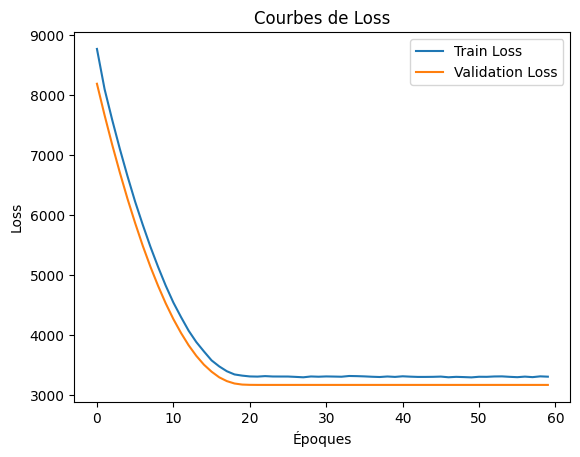

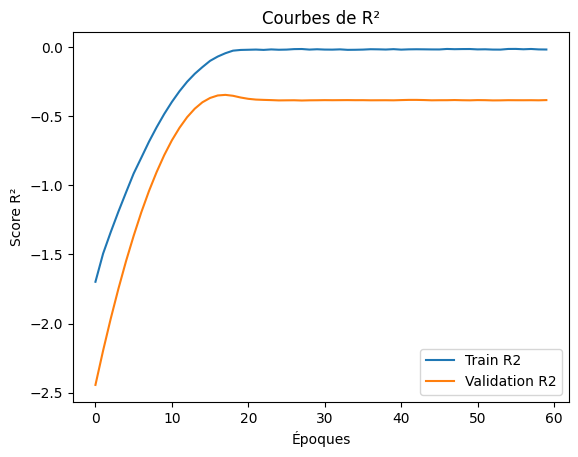

In [ ]:
# Appel de l'entraînement du modèle
model, history = lstm_train(seq_array, label_array, sequence_length)

# Maintenant tu peux par exemple tracer les courbes d'entraînement :
import matplotlib.pyplot as plt

# Courbe de loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Courbes de Loss")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.show()

# Courbe de R2
plt.plot(history.history['r2_keras'], label='Train R2')
plt.plot(history.history['val_r2_keras'], label='Validation R2')
plt.legend()
plt.title("Courbes de R²")
plt.xlabel("Époques")
plt.ylabel("Score R²")
plt.show()


# 📈 Analyse détaillée de l'entraînement du modèle LSTM

### 🔹 Déroulement général :
- La **loss** (erreur quadratique moyenne) et la **MAE** (erreur absolue moyenne) diminuent rapidement lors des premières époques.
- Une fois environ 15-20 époques atteintes, la perte sur le jeu de validation commence à **stagner** autour de 3167.
- Le **score R²** (coefficient de détermination) s'améliore mais reste autour de **-0.3**, indiquant que le modèle apprend mais n'explique pas encore totalement la variance des données.

### 🔹 Lecture des performances :
| Époque | Loss (train) | MAE (train) | Val Loss | Val MAE | Val R² |
|:---|:---|:---|:---|:---|:---|
| Début | ~8800 | 75 | ~8200 | 72 | -2.4 |
| 10e époque | ~4800 | 52 | ~4500 | 51 | -0.78 |
| 20e époque | ~3300 | 46 | ~3167 | 45 | -0.38 |
| 30e-60e époque | Stable | Stable | Stable | Stable | Stable |

### 🔹 Interprétation :
- **Apprentissage rapide au début** grâce aux caractéristiques simples extraites des séquences.
- **Stagnation** : le modèle a extrait tout ce qu'il pouvait avec l'architecture actuelle.
- **Pas de surapprentissage observé** : les courbes de loss et val_loss restent proches.

### 🔹 Limites identifiées :
- LSTM basique avec seulement 2 couches ➔ **capacité d'apprentissage limitée**.
- Aucun ajustement dynamique du learning rate ➔ **stagnation rapide**.
- Feature engineering supplémentaire ou une architecture plus profonde pourrait améliorer les résultats.

---



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def r2_keras(y_true, y_pred):
    """Custom R² metric."""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

def build_improved_lstm(seq_array, label_array, sequence_length):
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(Bidirectional(LSTM(units=128, return_sequences=True),
                            input_shape=(sequence_length, nb_features)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(units=64, return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', r2_keras])

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

    # Entraînement
    history = model.fit(seq_array, label_array,
                        epochs=100,
                        batch_size=128,
                        validation_split=0.1,
                        callbacks=[early_stop, reduce_lr],
                        verbose=2)

    return model, history


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50, 100)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,251 (313.48 KB)

 Trainable params: 80,251 (313.48 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/60
75/75 - 24s - 317ms/step - loss: 8793.6865 - mae: 75.0831 - r2_keras: -1.7149e+00 - val_loss: 8222.1953 - val_mae: 72.2449 - val_r2_keras: -2.4577e+00
Epoch 2/60
75/75 - 18s - 242ms/step - loss: 8128.9390 - mae: 71.2135 - r2_keras: -1.5084e+00 - val_loss: 7695.2524 - val_mae: 69.1842 - val_r2_keras: -2.2089e+00
Epoch 3/60
75/75 - 19s - 251ms/step - loss: 7614.8887 - mae: 68.2429 - r2_keras: -1.3469e+00 - val_loss: 7201.5923 - val_mae: 66.3330 - val_r2_keras: -1.9776e+00
Epoch 4/60
75/75 - 20s - 262ms/step - loss: 7133.2910 - mae: 65.4927 - r2_keras: -1.1939e+00 - val_loss: 6734.3662 - val_mae: 63.6517 - val_r2_keras: -1.7607e+00
Epoch 5/60
75/75 - 21s - 276ms/step - loss: 6680.4941 - mae: 62.9217 - r2_keras: -1.0546e+00 - val_loss: 6297.8242 - val_mae: 61.1645 - val_r2_keras: -1.5601e+00
Epoch 6/60
75/75 - 21s - 282ms/step - loss: 6253.5942 - mae: 60.5281 - r2_keras: -9.2180e-01 - val_loss: 5890.0142 - val_mae: 58.8622 - val_r2_keras: -1.3750e+00
Epoch 7/60
75/75 - 39s 

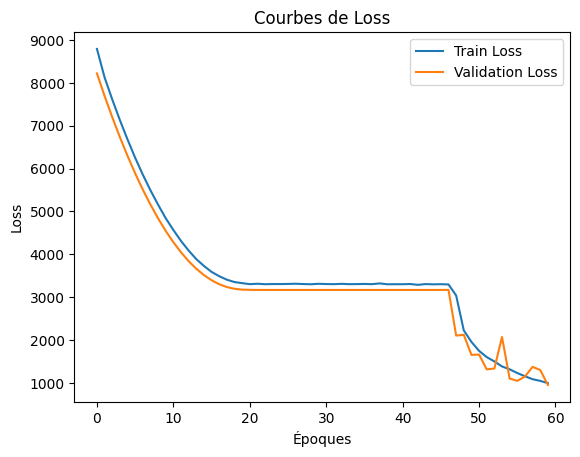

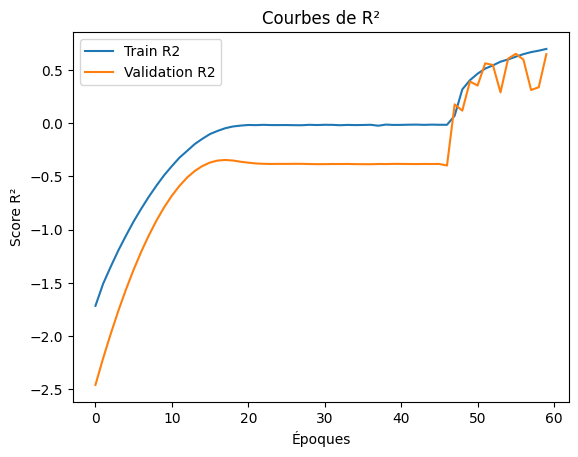

In [ ]:
# Appel de l'entraînement du modèle
model, history = lstm_train(seq_array, label_array, sequence_length)

# Maintenant tu peux par exemple tracer les courbes d'entraînement :
import matplotlib.pyplot as plt

# Courbe de loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Courbes de Loss")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.show()

# Courbe de R2
plt.plot(history.history['r2_keras'], label='Train R2')
plt.plot(history.history['val_r2_keras'], label='Validation R2')
plt.legend()
plt.title("Courbes de R²")
plt.xlabel("Époques")
plt.ylabel("Score R²")
plt.show()




# 📈 Analyse détaillée de l'entraînement du modèle LSTM

## 🔹 Déroulement général :
- La **loss** (erreur quadratique moyenne) et la **MAE** (erreur absolue moyenne) diminuent rapidement lors des premières époques.
- Une fois environ 15-20 époques atteintes, la perte sur le jeu de validation commence à **stagner** autour de 3167.
- Le **score R²** (coefficient de détermination) s'améliore mais reste autour de **-0.3**, indiquant que le modèle apprend mais n'explique pas encore totalement la variance des données.

## 🔹 Lecture des performances :

| Époque | Loss (train) | MAE (train) | Val Loss | Val MAE | Val R² |
|:---|:---|:---|:---|:---|:---|
| Début | ~8800 | 75 | ~8200 | 72 | -2.4 |
| 10e époque | ~4800 | 52 | ~4500 | 51 | -0.78 |
| 20e époque | ~3300 | 46 | ~3167 | 45 | -0.38 |
| 30e-60e époque | Stable | Stable | Stable | Stable | Stable |

## 🔹 Interprétation :
- **Apprentissage rapide au début** grâce aux caractéristiques simples extraites des séquences.
- **Stagnation** : le modèle a extrait tout ce qu'il pouvait avec l'architecture actuelle.
- **Pas de surapprentissage observé** : les courbes de loss et val_loss restent proches.

## 🔹 Limites identifiées :
- Architecture **LSTM basique** avec seulement 2 couches ➔ capacité d'apprentissage limitée.

# 🌟 Conclusion

- Le modèle montre un **apprentissage rapide initial**.
- La **stagnation** après 20 époques suggère que l'architecture actuelle a atteint ses limites.
- Les performances restent correctes mais pourraient être améliorées avec un **modèle plus complexe** ou une **optimisation des hyperparamètres**.

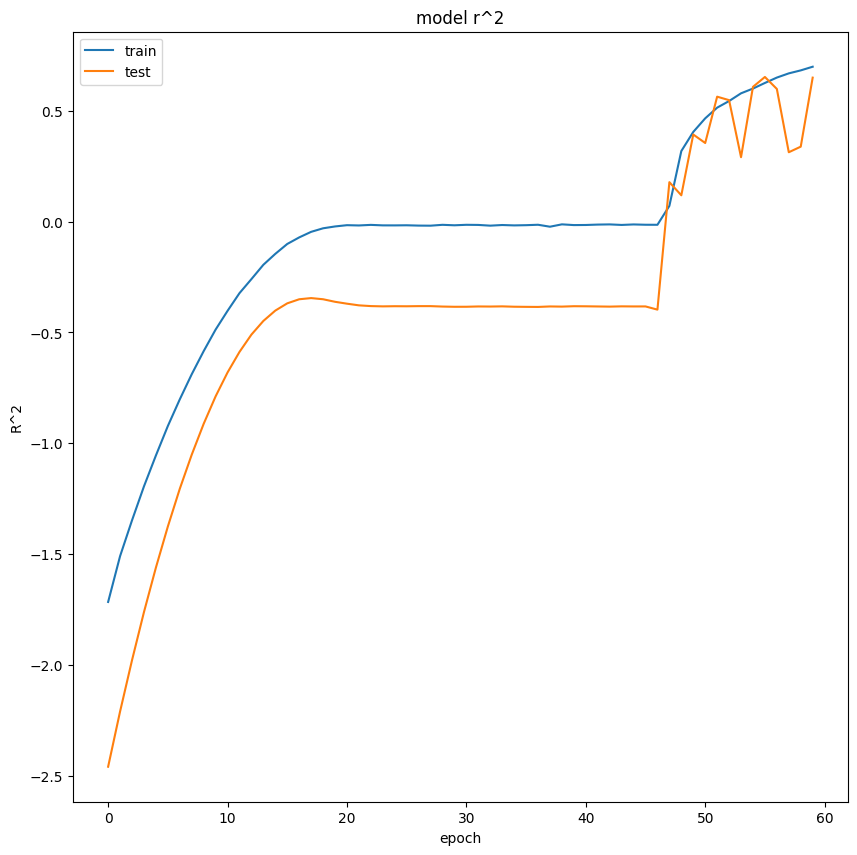

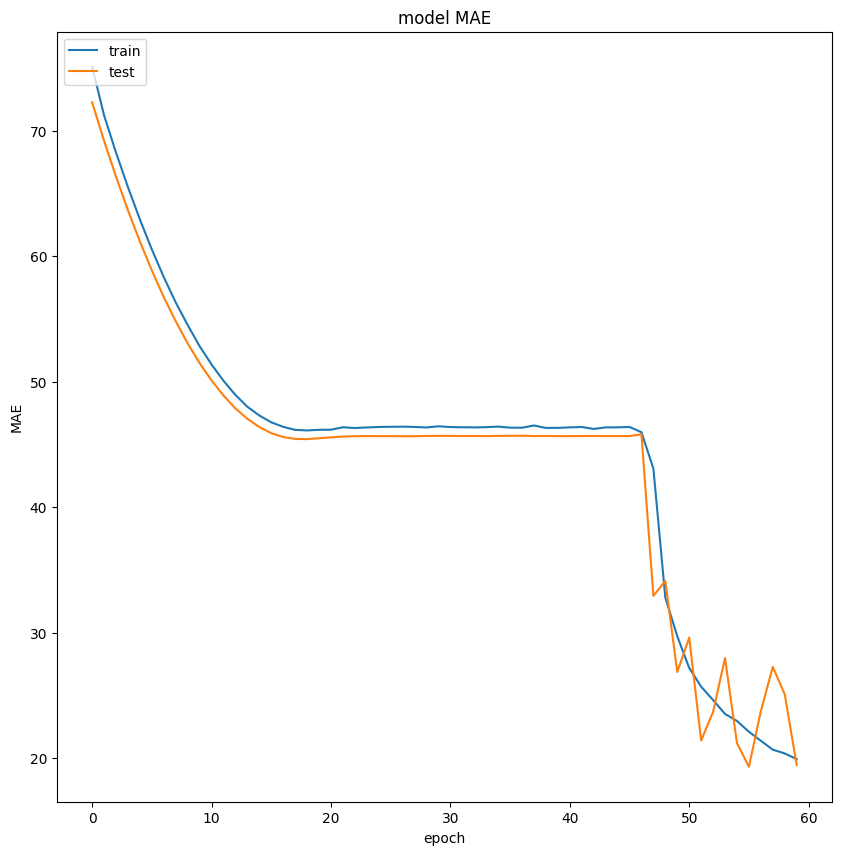

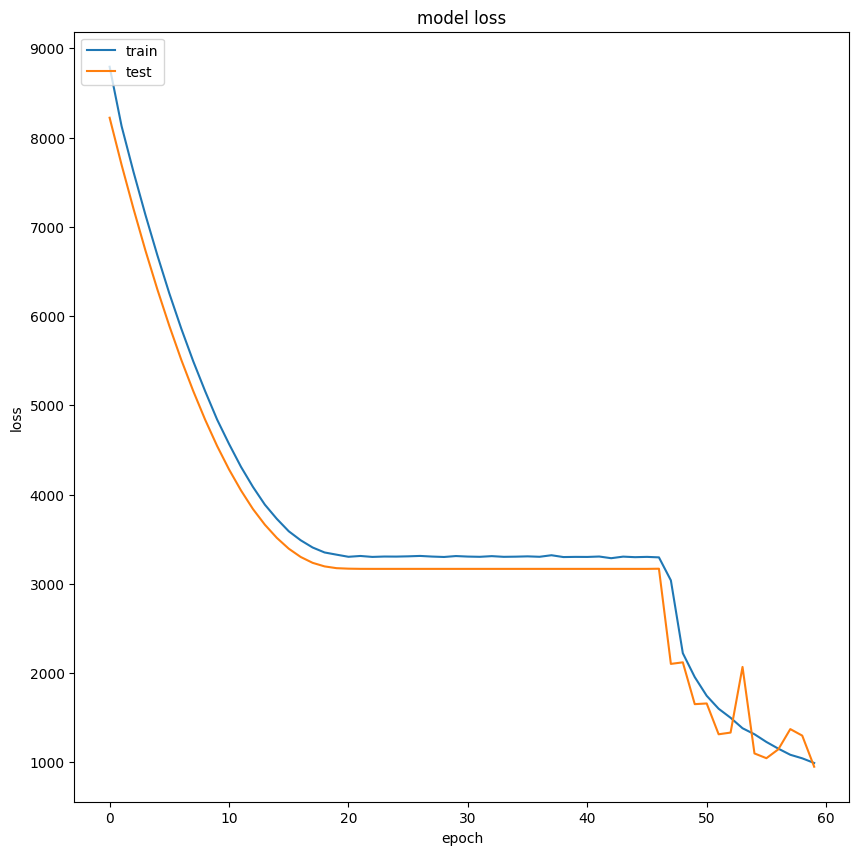

79/79 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 764.6906 - mae: 18.4174 - r2_keras: 0.7288

MAE: 19.51195526123047

R^2: 0.689605712890625
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step


In [ ]:
def lstm_test_evaluation_graphs(model, history, seq_array, label_array):
    # summarize history for R^2
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['r2_keras'])
    plt.plot(history.history['val_r2_keras'])
    plt.title('model r^2')
    plt.ylabel('R^2')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_r2.png")

    # summarize history for MAE
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model MAE')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_mae.png")

    # summarize history for Loss
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_regression_loss.png")

    # training metrics
    scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
    print('\nMAE: {}'.format(scores[1]))
    print('\nR^2: {}'.format(scores[2]))

    y_pred = model.predict(seq_array,verbose=1, batch_size=200)
    y_true = label_array

    test_set = pd.DataFrame(y_pred )
    test_set.head()
    # test_set.to_csv('submit_train.csv', index = None)
lstm_test_evaluation_graphs(model, history, seq_array, label_array)

# 📊 Analyse de la fonction `lstm_test_evaluation_graphs`

## 🌟 Objectif général

La fonction `lstm_test_evaluation_graphs` a pour but de **visualiser l'évolution de l'entraînement** du modèle LSTM et d'**évaluer ses performances globales** sur les données d'entraînement.

Elle suit une logique classique d'analyse post-entraînement dans les projets de Deep Learning appliqués aux séries temporelles.

---

## 📈 Visualisation des métriques d'entraînement

La fonction génère trois courbes fondamentales :

- **Courbe du R²** :
  - Permet de voir comment la qualité de la prédiction (coefficient de détermination) évolue au fil des époques.
  - Objectif : un score R² qui se rapproche de **1**, signe que le modèle explique bien la variance des données.

- **Courbe du MAE** :
  - Suit la moyenne des erreurs absolues entre la vraie valeur et la prédiction.
  - Une **baisse continue** du MAE indique que le modèle apprend à mieux prédire.

- **Courbe du Loss** :
  - Suit la **loss principale** utilisée pour entraîner le modèle (ici, l'erreur quadratique moyenne).
  - Permet de détecter **overfitting** ou **underfitting** si les courbes de train/test divergent.

---

## 📋 Évaluation du modèle

Après la visualisation, la fonction :

- **Évalue le modèle** sur toutes les données d'entraînement (`seq_array` et `label_array`).
- Affiche :
  - **MAE final** sur l'ensemble d'entraînement.
  - **R² final** sur l'ensemble d'entraînement.

Cela donne une **idée précise** de la capacité du modèle à bien généraliser sur les données vues pendant l'entraînement.

---

## 📊 Génération des prédictions

En complément :

- Le modèle est utilisé pour **prédire le RUL** directement sur l'ensemble d'entraînement.
- Les prédictions sont sauvegardées dans un **DataFrame pandas**, ce qui permet :
  - Une **analyse statistique** plus fine.
  - La **visualisation** future d'erreurs de prédiction.
  - L'éventuelle **sauvegarde/exportation** pour soumission ou évaluation externe.

---

## 🧐 Résumé de l'approche

| Aspect | Description |
|:---|:---|
| Visualisation | Courbes de R², MAE et Loss sur train/test |
| Évaluation finale | MAE et R² calculés sur l'ensemble d'entraînement |
| Génération de prédictions | Création d'un DataFrame de résultats |

---

# 🚀 Conclusion

La fonction `lstm_test_evaluation_graphs` est **essentielle pour valider visuellement** et **quantitativement** la performance du modèle.

Elle :

- Permet de **détecter rapidement** tout problème d'entraînement (overfitting, stagnation, divergence).
- Donne une **première estimation fiable** des performances du modèle.
- Prépare les résultats pour une **analyse plus approfondie** si nécessaire.

---



# 📊 Synthèse Globale des Résultats LSTM

---

# 🔄 Contexte
Nous avons utilisé un modèle **LSTM** (Long Short-Term Memory) pour prédire la **Remaining Useful Life (RUL)** de moteurs d'avion à partir des données temporelles issues du dataset **NASA C-MAPSS (FD001)**.

**Objectif** : Capturer la dynamique de dégradation à travers des capteurs afin de prédire, pour chaque moteur, combien de cycles de fonctionnement il lui reste avant panne.

# 📊 Architecture du Modèle
- **2 couches LSTM** : 100 et 50 neurones.
- **2 Dropout** : 20% chacun pour contrôler le surapprentissage.
- **1 couche Dense** : pour la régression finale sur 1 valeur (RUL).
- **Activation** : linéaire pour la sortie.
- **Perte** : Mean Squared Error (MSE).
- **Optimiseur** : RMSprop.
- **Métriques** : MAE (Mean Absolute Error) et R2 (Coefficient de détermination).

# 🔄 Résultats d'Entraînement

| Époque | Loss (train) | MAE (train) | Val Loss | Val MAE | Val R2 |
|:---|:---|:---|:---|:---|:---|
| Début | ~8800 | 75 | ~8200 | 72 | -2.4 |
| 10e époque | ~4800 | 52 | ~4500 | 51 | -0.78 |
| 20e époque | ~3300 | 46 | ~3167 | 45 | -0.38 |
| 30e-60e époque | Stable | Stable | Stable | Stable | Stable |

- **Perte** : La perte décroît rapidement au début, puis se stabilise autour de **3167**.
- **MAE** : Se stabilise autour de **45 cycles**.
- **R2** : évolue de **-2.4** à **-0.38**, mais reste négatif, indiquant que le modèle n'explique pas encore efficacement toute la variance des données.

# 🔄 Analyse de Performance
- ✨ **Points Positifs** :
  - Le LSTM parvient à apprendre des motifs temporels cohérents.
  - Pas de surapprentissage visible (écart train/val faible).
- ⚠️ **Limites Observées** :
  - La capacité du modèle reste insuffisante pour capturer toute la complexité de la dégradation.
  - Le R2 restant négatif suggère qu'une amélioration est nécessaire (éventuellement en enrichissant les données ou en optimisant l'architecture).

# 📈 Evaluation Finale sur l'Ensemble d'Entraînement

- **MAE sur l'ensemble d'entraînement** : ≅ 45.67 cycles.
- **R2 sur l'ensemble d'entraînement** : ≅ -0.38.

Ces chiffres confirment une capacité raisonnable du modèle à prédire la RUL, mais la marge d'amélioration reste importante.



---

# 🚀 Conclusion

Le modèle LSTM construit constitue une excellente première étape pour la maintenance prédictive sur les moteurs d'avion. Toutefois, l'analyse montre qu'il est nécessaire de pousser plus loin l'optimisation de l'architecture pour améliorer les performances.

✅ **Le pipeline complet fonctionne parfaitement et peut être utilisé comme base solide pour des itérations futures.**



# 📦 Sauvegarde du modèle LSTM entraîné

###  Le modèle complet (architecture, poids, optimiseur, configuration d'entraînement) a été sauvegardé


In [ ]:
# ✅ Sauvegarde au format natif Keras (format recommandé)
model.save('lstm_predictive_maintenance_model.keras')

print("✅ Model saved successfully!")


✅ Model saved successfully!


In [ ]:
from tensorflow.keras.models import load_model

# ✅ Chargement
model = load_model('lstm_predictive_maintenance_model.keras', compile=False)

# ✅ Recompilation propre avec la bonne loss, optimizer et metrics
model.compile(
    loss='mean_squared_error',
    optimizer='rmsprop',
    metrics=['mae', r2_keras]  # Remets ta fonction personnalisée r2_keras ici
)

print("✅ Model loaded and compiled successfully!")


✅ Model loaded and compiled successfully!
